# Pipeline with fully simulated setup

Can we capture the true ATE using estimated labels? Let's do a simulation! Let's try to keep things simple:

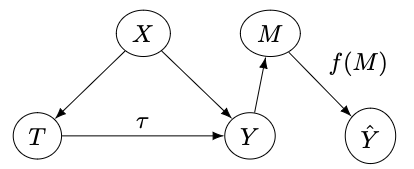

- $X$ is some confounder (e.g. urban/rural where urban areas are wealthier *and* more likely to be treated)
- $T$ is the treatment with a treatment effect $\tau$, (e.g. World Bank intervention)
- $Y$ is the outcome (change in IWI)

In our setting, we usually can't observe IWI directly. Instead, we have to rely on proxy values obtained from EO-ML.

- $M$ is the data we can observe, i.e. the satellite image. In reality, this is most likely influenced by both $X$ and $T$, but we keep it simple.
- $\hat{Y}$ is the estimate of $Y$ that we get by passing our image through the EO-ML model, $f(M)$.

In [35]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

RANDOM_STATE = 42

For this to work, there must be some function `m_func(Y)` that generates an "image embedding" $M$ from a wealth level $Y$. Here, we say that this is a simple first degree polynomial, such that:

$$
M = \begin{bmatrix}
           2Y \\
           3Y \\
           -4Y
         \end{bmatrix} + \epsilon
$$

In [2]:
# Define a simple first-order function to generate M from Y
m_func = lambda Y: np.vstack([2 * Y, 3 * Y, -4 * Y]).T

I generate some samples in accordance with the DAG and `m_func` above. 

In [3]:
def generate_population(m_func, n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_M=0.5, seed=42):
    """
    Generates a synthetic population for causal inference simulations.

    Parameters:
    m_func (function): A function that takes Y as input and returns a proxy M.
    n_samples (int, optional): Number of samples to generate. Default is 10000.
    tau (float, optional): True Average Treatment Effect (ATE) of treatment T. Default is 2.0.
    alpha (float, optional): Effect of confounder X on outcome Y. Default is 1.0.
    sigma_Y (float, optional): Standard deviation of noise in outcome Y. Default is 1.0.
    sigma_M (float, optional): Standard deviation of noise in proxy M. Default is 0.5.
    seed (int, optional): Random seed for reproducibility. Default is 42.

    Returns:
    pd.DataFrame: A DataFrame containing the generated population with columns:
        - 'X': Confounder values.
        - 'T': Treatment assignment.
        - 'Y': Outcome values.
        - 'p_T_given_X': Probability of treatment given confounder X.
        - 'M': Proxy values for outcome Y.
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate confounder X ~ N(0, 1)
    X = np.random.normal(0, 1, n_samples)

    # Generate treatment T ~ Bernoulli(p(X)) where p(X) is a logistic function of X
    p_T_given_X = 1 / (1 + np.exp(-X))  # Logistic function
    T = np.random.binomial(1, p_T_given_X)

    # Generate outcome Y ~ N(tau * T + alpha * X, sigma_Y)
    Y = tau * T + alpha * X + np.random.normal(0, sigma_Y, n_samples)

    # Generate proxy M = m_func(Y) + noise
    M = m_func(Y)
    M += np.random.normal(0, sigma_M, M.shape)

    population = pd.DataFrame({
        'X': X,
        'T': T,
        'Y': Y,
        'p_T_given_X': p_T_given_X,
        'M': list(M)
    })

    return population

I setup some code for traing a function $f(M)$ under the constraint that $Y \bot (Y - f(M))$

I also add code for "calibrating" these (to predict a confidence distribution instead of a point estimate)

In [4]:
class CDF_model:
    
    def __init__(self, alpha: float=1e-1):
        self.alpha = alpha # Not used atm
            
    # Objective function (squared residuals)
    def objective(self, beta, M, y):
        residuals = M @ beta - y
        return np.sum(residuals**2)

    # Constraint: y^T(Mβ - y) = 0
    def constraint(self, beta, M, y):
        residuals = M @ beta - y
        return y.T @ residuals
        
    def fit(self, M_train, y_train):
        
        # Use unconstrained OLS as initial guess for beta
        beta_ols = LinearRegression().fit(M_train, y_train).coef_

        # Define the constraint as a dictionary for `scipy.optimize.minimize`
        constr = {'type': 'eq', 'fun': self.constraint, 'args': (M_train, y_train)}

        # Solve the constrained optimization problem
        result = minimize(self.objective, beta_ols, args=(M_train, y_train), constraints=constr)

        # Extract the solution
        self.beta = result.x
        if not result.success:
            raise ValueError('Optimizer did not converge')
        
    def calibrate(self, M_cal, y_cal):
        # Predict the outcomes for the calibration set
        y_pred = M_cal @ self.beta
        
        # Calculate and sort the residuals
        self.residuals = np.sort(y_cal - y_pred)
        
    def predict(self, M_test):
        # Predict the outcomes for the test set
        y_pred = M_test @ self.beta
        
        # Repeat the predictions to match the number of residuals
        y_pred = np.repeat(y_pred[:, np.newaxis], len(self.residuals), axis=1)
        
        # Add the sorted residuals to the predictions. This will give us a distribution of predictions
        y_pred += self.residuals
        
        return y_pred

In [5]:
def get_ate(t, y_preds, p_t):
    """
    Calculate the Average Treatment Effect (ATE) using Inverse Probability of Treatment Weighting (IPTW).
    Parameters:
    t (array-like): Binary treatment indicator (1 if treated, 0 if control).
    y_preds (array-like): Predicted outcomes.
    p_t (array-like): Propensity scores (probability of receiving treatment).
    Returns:
        float: Estimated average treatment effect (ATE).
    """
    
    # Calculate IPTW weights
    weights_treated = t / p_t
    weights_control = (1 - t) / (1 - p_t)

    # Calculate weighted outcomes
    weighted_outcome_treated = weights_treated * y_preds
    weighted_outcome_control = weights_control * y_preds

    # Estimate the average treatment effect (ATE)
    return np.mean(weighted_outcome_treated - weighted_outcome_control)

In [6]:
# Phase 1
def fit_and_calibrate_model(M_train, Y_train, seed=42):
    """
    Fits and calibrates a model using the provided training data.
    Parameters:
    M_train (array-like): The feature matrix for training the model.
    Y_train (array-like): The target values corresponding to M_train.
    seed (int, optional): The random seed for splitting the data. Default is 42.
    Returns:
        model (CDF_model): The fitted and calibrated model.
    """
    
    # Split into train and calibration set
    M_train, M_cal, Y_train, Y_cal = train_test_split(M_train, Y_train, test_size=.25, random_state=seed)
    
    # Fit model and calibrate on D_train  
    model = CDF_model()
    model.fit(M_train, Y_train)
    model.calibrate(M_cal, Y_cal)
    return model

# Phase 2
def estimate_ate_with_model(model, M_trial, t_trial, p_T_trial, n_cdf_rounds=1000, seed=42):
    """
    Estimate the Average Treatment Effect (ATE) using a given model.
    Parameters:
    model (CDF_model): The predictive model that provides the conditional distribution of the outcome.
    M_trial (array-like): The matrix of covariates for the trial data.
    t_trial (array-like): The treatment assignment vector for the trial data.
    p_T_trial (array-like): The propensity scores for the trial data.
    n_cdf_rounds (int, optional): The number of rounds to draw from the CDFs (default is 1000).
    seed (int, optional): The random seed for reproducibility (default is 42).
    Returns:
        ate_estimates (list): A list of ATE estimates from each draw.
    """
    
    y_pred_dists = model.predict(M_trial)
    n_samples, n_quantiles = y_pred_dists.shape
    ate_estimates = []
    np.random.seed(seed)
    
    # Make 'n_cdf_rounds' draws from the CDFs
    for i in range(n_cdf_rounds):
        indices = np.random.randint(0, n_quantiles, n_samples)
        draw_y_preds = y_pred_dists[np.arange(n_samples), indices]

        # Get ATE estimate for this draw
        ate_estimate = get_ate(t_trial, draw_y_preds, p_T_trial)
        ate_estimates.append(ate_estimate)
        
    return ate_estimates

In [16]:
def run_boot(D_train, D_trial, bootstrap_train=False, bootstrap_trial=False, seed=42):
    """
    Run the bootstrap procedure for estimating the average treatment effect (ATE).
    Parameters:
    D_train (tuple): A tuple containing the training data (M_train, Y_train).
        - M_train: Features for the training data.
        - Y_train: Labels for the training data.
    D_trial (tuple): A tuple containing the trial data (M_trial, t_trial, p_T_trial).
        - M_trial: Features for the trial data.
        - t_trial: Treatment assignments for the trial data.
        - p_T_trial: Propensity scores for the trial data.
    bootstrap_train (bool, optional): If True, resample the training data with replacement. Default is False.
    bootstrap_trial (bool, optional): If True, resample the trial data with replacement. Default is False.
    seed (int, optional): Random seed for reproducibility. Default is 42.
    Returns:
        ate_estimates (list): Estimated average treatment effects.
    """
    
    M_train, Y_train = D_train
    M_trial, t_trial, p_T_trial = D_trial
    
    # Sample with replacement
    if bootstrap_train:
        M_train, Y_train = resample(M_train, Y_train, random_state=seed)
    if bootstrap_trial:
        M_trial, t_trial, p_T_trial = resample(M_trial, t_trial, p_T_trial, random_state=seed)
    
    # Phase 1
    model = fit_and_calibrate_model(M_train, Y_train, seed=seed)
    
    # Phase 2
    ate_estimates = estimate_ate_with_model(model, M_trial, t_trial, p_T_trial, seed=seed)
    
    return ate_estimates

Run the experiment and see how well it works!

In [47]:
# Generate population
tau = 2.0
n_samples = 10000
  
population = generate_population(m_func, tau=tau, n_samples=n_samples, seed=RANDOM_STATE)

# Split into train and trial sets
train_pop, trial_pop = train_test_split(population, test_size=.2, random_state=RANDOM_STATE)
D_train = (np.vstack(train_pop['M'].values), train_pop['Y'].values)
D_trial = (np.vstack(trial_pop['M'].values), trial_pop['T'].values, trial_pop['p_T_given_X'].values)

target_tau = get_ate(trial_pop['T'].values, trial_pop['Y'].values, trial_pop['p_T_given_X'].values)
print(r'Estimated $\tau$ using true labels of $D_{trial}$:', target_tau)

Estimated $\tau$ using true labels of $D_{trial}$: 2.0854825404296697


In [48]:
n_boots = 1000
ate_estimates = []

# Run the bootstrap procedure
for i in tqdm(range(n_boots)):

    boot_ate_ests = run_boot(D_train, D_trial, bootstrap_train=True, bootstrap_trial=True, seed=i)
    ate_estimates.append(boot_ate_ests)
    
ate_estimates = np.asarray(ate_estimates)

100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s]


## Results

The model is able to predict the treatment $\tau$ without any signs of bias. At the moment, the modeling error is very small on account of the simple setup. The lion's share of the error is therefore due to sampling. As such, adding the modeling error doesn't affect the confidence intervals much.

Note that the "true" value of $\tau$ and the one from the trial set might differ slightly due to limited samples.

In [49]:
def calculate_errors(ate_estimates):
    
    # Calculate variance of ATE estimates within each bootstrap sample (for modeling error)
    row_variances = ate_estimates.var(axis=1)  # Variance within each bootstrap sample
    modeling_error = np.sqrt(row_variances.mean())  # Average variance and take sqrt
    
    # Calculate mean of ATE estimates for each bootstrap sample (for sampling error)
    row_means = ate_estimates.mean(axis=1)  # Mean for each bootstrap sample
    sampling_error = np.sqrt(row_means.var(ddof=1))  # Variance of the means and take sqrt
    
    return modeling_error, sampling_error

modeling_error, sampling_error = calculate_errors(ate_estimates)

global_mean = ate_estimates.mean()
z = norm.ppf(0.975)

# Confidence Interval using Sampling Error only
ci_sampling_only = (global_mean - z * sampling_error, global_mean + z * sampling_error)

# Total error combining modeling and sampling errors
total_error = np.sqrt(sampling_error**2 + modeling_error**2)

# Confidence Interval using both errors
ci_with_both_errors = (global_mean - z * total_error, global_mean + z * total_error)

print('Mean estimated ATE:', global_mean)
print('Sampling error:', sampling_error)
print('Modeling error:', modeling_error)
print(f'95% Confidence interval with just sampling error: ({ci_sampling_only[0]:.3f} - {ci_sampling_only[1]:.3f})')
print(f'95% Confidence interval with both model and sampling error: ({ci_with_both_errors[0]:.3f} - {ci_with_both_errors[1]:.3f})')

Mean estimated ATE: 2.0889856710006236
Sampling error: 0.08222581761862575
Modeling error: 0.004703281770268229
95% Confidence interval with just sampling error: (1.928 - 2.250)
95% Confidence interval with both model and sampling error: (1.928 - 2.250)


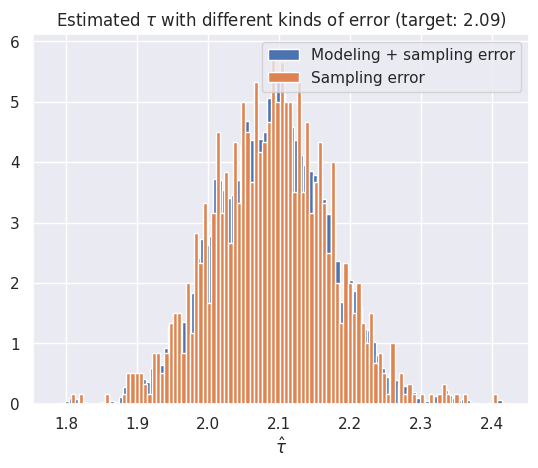

In [53]:
plt.hist(ate_estimates.flatten(), bins=100, density=True, label='Modeling + sampling error')
plt.hist(ate_estimates.mean(axis=1), bins=100, density=True, label='Sampling error')
plt.xlabel(r'$\hat{\tau}$')
plt.title(fr'Estimated $\tau$ with different kinds of error (target: {target_tau:.2f})')
plt.legend()
plt.show()